# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
---
    
   **Objective**:
        The goal of this project is to extract data from a picture of a road to determine the location of the lane 
        lines in the image
        
        Each image from a folder of test images will go through a process to extrace the data and plot the location of the lane lines visually for the user
        
        * Import Image
        * Convert Image to grayscale
        * Blur the image to reduce noise
        * Find the edges of lines in the image
        * Extrapolate the major lines in the image
        * Plot the lines over the original picture

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def show(img):
    """
    Display the image to the user:
        - determine if the image is gray or rgb
        - display image with correct encoding
    
    """
    if len(img.shape) > 2:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap = 'gray')

def grayscale(img):
    """Applies the Grayscale transform
        call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Frame Class

In [3]:
class Frame(object):
    
    def __init__(self, image):
        """Return a new Image Object"""
        self.color = image
        self.size = (self.color.shape[1], self.color.shape[0]) # xMax, yMax
        self.xMax = self.color.shape[1]
        self.yMax = self.color.shape[0]
            
    def show(self):
        plt.imshow(self.color)
        
    def grayScale(self):
        grayImage = np.copy(self.color)
        return cv2.cvtColor(grayImage, cv2.COLOR_RGB2GRAY)

    def getVertices(self):
        imshape = self.color.shape
        top_left = (450, imshape[0]/2)
        bottom_left = (0, imshape[0])
        top_right = (450, imshape[0]/2)
        bottom_right = (imshape[1], imshape[0])

        vertices = np.array([[(bottom_left),top_left, (top_right), (bottom_right)]], dtype=np.int32)
        return vertices
    
    def masked(self):
        vertices = self.getVertices()
        grayPic = self.grayScale()
        return region_of_interest(grayPic, vertices)

## Import Images into an Array

The first step is to import the images from the file

In [4]:
# Import the Images into an Array
import glob
images = []
for file in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(file)
    images.append(image)

Show the first image before it's been processed

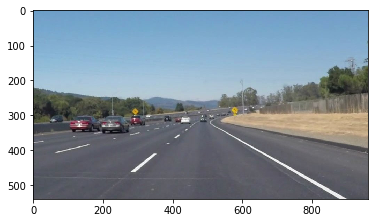

In [5]:
frame1 = Frame(images[0])
show(frame1.color)

# Convert to GrayScale

Next, convert the RGB image to grayscale.

With a grayscale image, its easier to detect lines in the image. Lines can be detected by looking for significan changes in the relative value of pixel brightness.

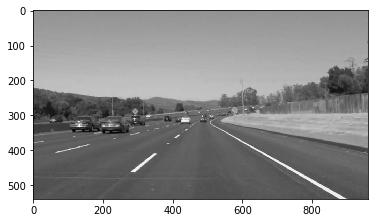

In [6]:
grayPic = frame1.grayScale()
show(grayPic)

## Gausian Blur
Next, we blur the image so that strong lines will stand out, and noise will fade into the background.

In [7]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.bilateralFilter(img, kernel_size, 75, 75)

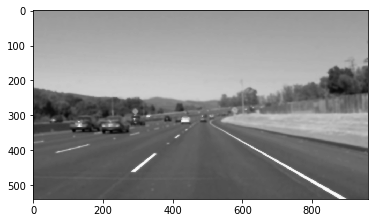

In [8]:
kernel_size = 9

blurPic = gaussian_blur(grayPic, kernel_size)
show(blurPic)

# Canny Edge Detection:
Then we look for edges in the picture by determining the areas of greatest change (highest gradient) among the gray pixels

In [9]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

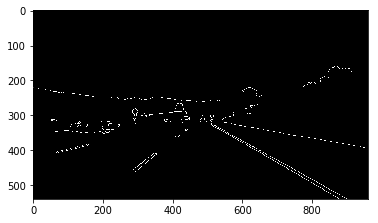

In [10]:
# Define Thresholds
low_threshold = 50
high_threshold = 150

# Create new picture from Canny Edge detection
edges_1 = canny(blurPic, low_threshold, high_threshold)
show(edges_1)

## Isolate Region of Interest
Because we know the aproximate location of the lanelines relative to the front of a car, we can get rid of lines outside of that aproximate location.

The "region of interest" is a triangle from the botom corners to the center of the image. We can ignore everything else.

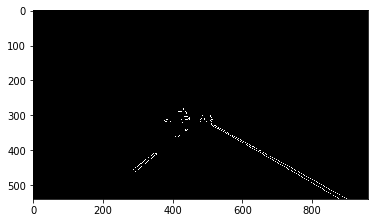

In [11]:
vertices = frame1.getVertices()
maskedPic = region_of_interest(edges_1, vertices)
show(maskedPic)

# Hough Transform
Next, we look for pixels that form straight lines.
We use a process called the Hough Transform. This process looks at each white pixel in the image and scans all the lines that pass through that pixel. It checks to see if other white pixels are on that line as well. The lines are saved in an array with their (x1, y1, x2, y2) coordinates of the line segments.

In [12]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

In [13]:
# Define the Hough transform parameters

rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1   # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 2    # maximum gap in pixels between connectable line segments

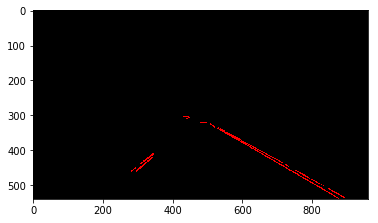

In [14]:
hough_image = hough_lines(maskedPic, rho, theta, threshold, min_line_length, max_line_gap)

show(hough_image)

# Plot the Hough Lines onto the original Image

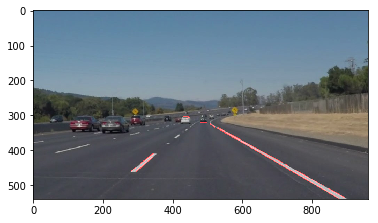

In [15]:
# Draw hough lines on the edge image
lines_edges = weighted_img(hough_image, frame1.color)
plt.imshow(lines_edges)

# Extrapolate Lines

Next, we extend the lines generated by the hough transform. This defines the boundaries of the lane.
1. Extrapolate Lane Lines
2. Plot lane lines over original image

### Extrapolate Lane Lines

In [16]:
def extrapolate_lines(line_array, top_of_image):
    # Array to store X and Y values for left and right lane lines
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    length_right = []
    length_left = []

    # Origin is in upper left corner
    top = top_of_image
    for line in line_array:
        for x1, y1, x2, y2 in line:
            # Move origin to bottom left corner
            y1 = top - y1
            y2 = top - y2

            # y = mx + b
            m = (y1 - y2) / (x1 - x2)
            b = y1 - (m*x1)

            # seperate left and right lane lines
            if m < -0.1 and b > 400:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)

            elif m > 0.1 and b < 70:
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)

    # Find Best Fit Lines
    rightSlope, rightIntercept = np.polyfit(right_x, right_y, 1)
    leftSlope, leftIntercept = np.polyfit(left_x, left_y, 1)
    
    right_lane_line = (rightSlope, rightIntercept)
    left_lane_line = (leftSlope, leftIntercept)
    
    return (right_lane_line, left_lane_line)

lines = cv2.HoughLinesP(maskedPic, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
right_line, left_line = extrapolate_lines(lines, frame1.color.shape[0])

### Draw extrapolated lines onto a blank image the same size as the original

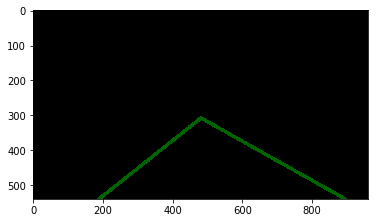

In [17]:
def draw_lane_lines(img, line1, line2):
    """
    line1, line2 = (m, b) for y = m(x) + b 
    img = original image
    
    """
    # Convert (y = mx + b) into (x1, y1, x2, y2)
    # x = -b/m
    
    rightSlope = line1[0]
    rightIntercept = line1[1]
    
    leftSlope = line2[0]
    leftIntercept = line2[1]
    
    # Use more readable variables
    bottom = img.shape[0]
    b = rightIntercept
    m = rightSlope
    x = int(-b/m)

    # Define the x-intercept of the right lane line
    rightLaneBottom = (x, bottom)

    #Left
    b = leftIntercept
    m = leftSlope
    x = int(-b/m)
    leftLaneBottom = (x, bottom)

    # solve for intersection of 2 lines
    a1 = rightSlope
    a2 = leftSlope
    b1 = rightIntercept
    b2 = leftIntercept

    # Solve for intersection of 2 lines
    a = np.array([[a1, -1], [a2, -1]])
    b = np.array([b1, b2])
    p = np.linalg.solve(a, b)
    
    # Convert intersection p into img coordinates
    intersection = (int(-(p[0])), int(540 + p[1]))

    # Create blank image
    projection = np.copy(img)*0
    GREEN = [0, 100, 0]

    # Draw Lines on Blank Image
    cv2.line(projection, rightLaneBottom, intersection, GREEN, thickness=10)
    cv2.line(projection, leftLaneBottom, intersection, GREEN, thickness=10)
    return projection

# Call Draw Lane Lines function
projection = draw_lane_lines(frame1.color, right_line, left_line)
show(projection)

### Merge the 'lane line' image and the orignial picture

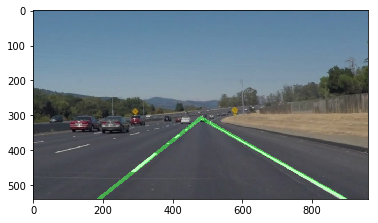

In [18]:
final_img = weighted_img(projection, frame1.color)
show(final_img)

# Save the processed final image to file

In [19]:
# Convert from RGB to BGR for saving the image
colorConverted = np.copy(final_img)
cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR, colorConverted)
cv2.imwrite('test_images/output/output1.jpg', colorConverted)

True

# Repeat for the rest of the images in 'test_images' directory

In [20]:
# Define Parameters:

# Gausian Blur Kernel Size
kernel_size = 5

# Canny Thresholds
low_threshold = 50
high_threshold = 150

# Hough Transform
rho = 1 
theta = np.pi/180 
threshold = 2   
min_line_length = 10
max_line_gap = 2

In [22]:
i = 0

for image in images:
    
    # Import imgage, convert to grayscale, and isolate region of interest
    frame1 = Frame(image)
    grayPic = frame1.grayScale()
    blurPic = gaussian_blur(grayPic, kernel_size)
    edges_1 = canny(blurPic, low_threshold, high_threshold)
    vertices = frame1.getVertices()
    maskedPic = region_of_interest(edges_1, vertices)
    
    # Find and average the Lane lines over 10 Images
    lines = cv2.HoughLinesP(maskedPic, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    right_line, left_line = extrapolate_lines(lines, image.shape[0])
    
    # Draw the lanes on the img
    projection = draw_lane_lines(frame1.color, right_line, left_line)
    final_img = weighted_img(projection, frame1.color)
    
    # Convert to BGR colorspace for saving
    colorConverted = np.copy(final_img)
    cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR, colorConverted)
    
    # Save to file
    file_name = 'test_images/output/output' + str(i) + '.jpg'
    cv2.imwrite(file_name, colorConverted)
    i += 1

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Average Lane Lines
Taking the average lane line over 10 frames creates a smoother video and reduces noise

In [24]:
# Define an array for storing the lane lines of each frame
smooth_right = []
smooth_left = []

def average_lines(newLine, laneLines, frames_to_smooth=10):
    """
    Take in the L+R lane lines from each frame.
    If less than 10 lines are saved, add the new lines to the array.
    Drop lines more than 10 frames old
    Average the lines in the array.
    Return the new averaged lines
    
    """
    
    # Append new lines until array has 10 frames
    if len(laneLines) < frames_to_smooth:
        laneLines.append(newLine)
    else:
        # Shift each frame down by 1. Drop the oldest.
        # Add newest frame to the end of the array.
        for n in range(1, frames_to_smooth):
            laneLines[n-1] = laneLines[n]
        
        laneLines[(frames_to_smooth)-1] = newLine
    
    # Take the average of all the lines in the array.
    average_line = np.average(laneLines, axis=0)
   
    return average_line

## Define the process for each frame of the video.
This is the same as the process for a single image, except that we will average the lane lines over 10 frames for a smoother output.

In [25]:
def process_image(image):
    """
    Process a single frame from a video stream.
    Identify lane lines and plot the line in green on the original image.
    
    """
    # Import imgage, convert to grayscale, and isolate region of interest
    frame1 = Frame(image)
    grayPic = frame1.grayScale()
    blurPic = gaussian_blur(grayPic, kernel_size)
    edges_1 = canny(blurPic, low_threshold, high_threshold)
    vertices = frame1.getVertices()
    maskedPic = region_of_interest(edges_1, vertices)
    
    # Find and average the Lane lines over 10 Images
    lines = cv2.HoughLinesP(maskedPic, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    right_line, left_line = extrapolate_lines(lines, image.shape[0])
    ave_right = average_lines(right_line, smooth_right)
    ave_left = average_lines(left_line, smooth_left)
    
    # Draw the lanes on the img and return to video
    projection = draw_lane_lines(frame1.color, ave_right, ave_left)
    final_img = weighted_img(projection, frame1.color)

    return final_img

#### Import the appropriate videos

In [26]:
# Define the output file locations
white_output = ("test_videos_output/solidWhiteRight.mp4")
yellow_output = ('test_videos_output/solidYellowLeft.mp4')

# Define the input file locations
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

# Process each frame in the video
white_clip = clip1.fl_image(process_image) 
yellow_clip = clip2.fl_image(process_image)

# Write the video to file
%time white_clip.write_videofile(white_output, audio=False)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.11 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:22<00:00, 30.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.4 s


# Display the final output

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
